# Imports

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
from openai import OpenAI

# Read test set

In [6]:
df_test = pd.read_csv('metastatic_local_test.csv', converters={'accept': literal_eval})

In [7]:
df_test = df_test.join(
    pd.get_dummies(df_test["accept"].explode()).groupby(level=0).sum()
)
df_test.head()

,doi,date,title,abstract,abstract_conclusions,abstract_introduction,abstract_methods,abstract_results,text,_input_hash,...,config,accept,answer,_timestamp,_annotator_id,_session_id,tumor_type,family,LOCAL,METASTATIC
0,10.1016/S1470-2045(15)00216-8,11/1/15,Bevacizumab with or without erlotinib as maint...,BACKGROUND: The combination of an anti-VEGF or...,INTERPRETATION: Maintenance bevacizumab plus e...,BACKGROUND: The combination of an anti-VEGF or...,"METHODS: This randomised, open-label, phase 3 ...","FINDINGS: Between Jan 1, 2007, and Oct 13, 201...",Bevacizumab with or without erlotinib as maint...,-523683350,...,{'choice_style': 'multiple'},[METASTATIC],accept,1715064809,2024-05-07_08-44-05,2024-05-07_08-44-05,"['Colorectal', 'General metastases']",Gastrointestinal,0,1
1,10.1016/S1470-2045(23)00147-X,5/1/23,Adjuvant chemotherapy following chemoradiother...,BACKGROUND: Standard treatment for locally adv...,INTERPRETATION: Adjuvant carboplatin and pacli...,BACKGROUND: Standard treatment for locally adv...,"METHODS: The OUTBACK trial was a multicentre, ...","FINDINGS: Between April 15, 2011, and June 26,...",Adjuvant chemotherapy following chemoradiother...,1531328663,...,{'choice_style': 'multiple'},[LOCAL],accept,1717406550,2024-06-03_10-57-37,2024-06-03_10-57-37,['Cervix'],Breast/Gynecological,1,0
2,10.1016/S1470-2045(13)70143-8,6/1/13,Photodynamic therapy versus topical imiquimod ...,BACKGROUND: Superficial basal-cell carcinoma i...,INTERPRETATION: Topical fluorouracil was non-i...,BACKGROUND: Superficial basal-cell carcinoma i...,"METHODS: In this single blind, non-inferiority...",FINDINGS: 601 patients were randomised: 202 to...,Photodynamic therapy versus topical imiquimod ...,71121558,...,{'choice_style': 'multiple'},[LOCAL],accept,1714751581,2024-05-03_17-48-50,2024-05-03_17-48-50,['Basal cell'],Skin/Soft tissue,1,0
3,10.1200/JCO.2005.04.1665,5/1/06,Sequential preoperative or postoperative docet...,PURPOSE: This study was designed to determine ...,CONCLUSION: The addition of preoperative or po...,PURPOSE: This study was designed to determine ...,PATIENTS AND METHODS: Women with operable brea...,RESULTS: Addition of T to AC did not significa...,Sequential preoperative or postoperative docet...,-1090471968,...,{'choice_style': 'multiple'},[LOCAL],accept,1714942534,2024-05-05_22-27-48,2024-05-05_22-27-48,['Breast'],Breast/Gynecological,1,0
4,10.1200/JCO.2008.19.4860,4/20/09,"Prospective, randomized trial of two different...",PURPOSE: There are limited prospective data on...,CONCLUSION: An increased complication rate was...,PURPOSE: There are limited prospective data on...,PATIENTS AND METHODS: During a 25-month period...,RESULTS: Two hundred twenty-one complications ...,"Prospective, randomized trial of two different...",-1792006351,...,{'choice_style': 'multiple'},"[LOCAL, METASTATIC]",accept,1714914755,2024-05-05_10-26-22,2024-05-05_10-26-22,"[""All""]",All,1,1


# Classify abstracts using GPT-4o

In [8]:
# Initialize the OpenAI client
client = OpenAI()

OpenAIError: The api_key client option must be set either by passing api_key to the client or by setting the OPENAI_API_KEY environment variable

In [ ]:
for index, row in df_test.iterrows():

    current_abstract = row["abstract"]

    # Let GPT-4o do the classification
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {
                "role": "system",
                "content": "You will be provided with the abstract of a cancer clinical trial. Your task will be to classify, if patients with metastatic disease were eligible for the trial or not. In addition, you will be asked to classify, if patients with localized or locally advanced disease, i.e. cancer that has not formed distant metastases, were eligible for the trial. Your output should look like this: METASTATIC: True/False, LOCAL: True/False. If you are unsure, please provide your best guess.",
            },
            {"role": "user", "content": f'{current_abstract}'},
        ],
        temperature=0.2,
    )

    # Add the response to the dataframe
    df_test.loc[index, "GPT-4o_response_raw"] = response.choices[0].message.content

In [ ]:
# Save the dataframe with the responses
df_test.to_csv("metastatic_local_test_with_gpt-4o_annotations.csv", index=False)

# Evaluate performance

In [9]:
df_test = pd.read_csv("metastatic_local_test_with_gpt-4o_annotations.csv")

In [10]:
# Create columns from the GPT-4o response
df_test["LOCAL_PREDICTED_GPT-4o"] = df_test["GPT-4o_response_raw"].apply(
    lambda x: 1 if "LOCAL: True" in x else 0
)

df_test["METASTATIC_PREDICTED_GPT-4o"] = df_test["GPT-4o_response_raw"].apply(
    lambda x: 1 if "METASTATIC: True" in x else 0
)



In [11]:
# Create combined labels column for ground truth
df_test.loc[(df_test["LOCAL"] == 1) & (df_test["METASTATIC"] == 0), "ALL_LABELS"] = (
    "Local_only"
)
df_test.loc[(df_test["LOCAL"] == 0) & (df_test["METASTATIC"] == 1), "ALL_LABELS"] = (
    "Metastatic_only"
)
df_test.loc[(df_test["LOCAL"] == 1) & (df_test["METASTATIC"] == 1), "ALL_LABELS"] = (
    "Both"
)
df_test.loc[(df_test["LOCAL"] == 0) & (df_test["METASTATIC"] == 0), "ALL_LABELS"] = (
    "Neither"
)

# Create combined labels column for GPT-4o
df_test.loc[(df_test["LOCAL_PREDICTED_GPT-4o"] == 1) & (df_test["METASTATIC_PREDICTED_GPT-4o"] == 0), "ALL_LABELS_GPT-4o"] = (
    "Local_only"
)
df_test.loc[(df_test["LOCAL_PREDICTED_GPT-4o"] == 0) & (df_test["METASTATIC_PREDICTED_GPT-4o"] == 1), "ALL_LABELS_GPT-4o"] = (
    "Metastatic_only"
)
df_test.loc[(df_test["LOCAL_PREDICTED_GPT-4o"] == 1) & (df_test["METASTATIC_PREDICTED_GPT-4o"] == 1), "ALL_LABELS_GPT-4o"] = (
    "Both"
)
df_test.loc[(df_test["LOCAL_PREDICTED_GPT-4o"] == 0) & (df_test["METASTATIC_PREDICTED_GPT-4o"] == 0), "ALL_LABELS_GPT-4o"] = (
    "Neither"
)

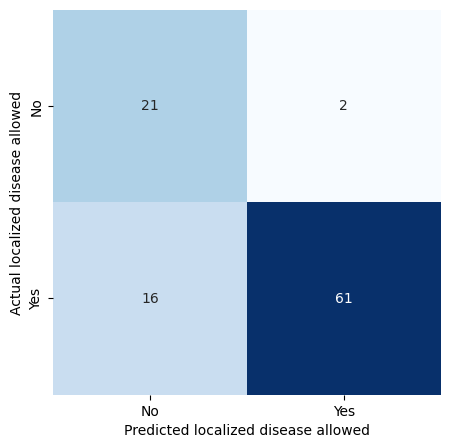

In [12]:
# Create confusion matrix of predicted and actual values for LOCAL
confusion_matrix = pd.crosstab(df_test["LOCAL"], df_test["LOCAL_PREDICTED_GPT-4o"])

# Plot the confusion matrix
fig = plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted localized disease allowed")
plt.ylabel("Actual localized disease allowed")
plt.xticks([0.5, 1.5], ["No", "Yes"])
plt.yticks([0.5, 1.5], ["No", "Yes"])
# Remove the colorbar but keep the width of the heatmap
plt.gca().collections[0].colorbar.remove()
plt.show()
fig.savefig("plots/confusion_matrix_local_gpt4o.png", dpi=300, bbox_inches="tight")

In [13]:
# Calculate the accuracy of the GPT-4o predictions for LOCAL
accuracy_local_gpt4o = (
    np.sum(df_test["LOCAL"] == df_test["LOCAL_PREDICTED_GPT-4o"]) / df_test.shape[0]
)

# Estimate the 95% confidence interval for the accuracy
accuracy_local_gpt4o_std = np.sqrt(
    accuracy_local_gpt4o * (1 - accuracy_local_gpt4o) / df_test.shape[0]
)
accuracy_local_gpt4o_CI = 1.96 * accuracy_local_gpt4o_std
print(
    f"Accuracy of GPT-4o predictions for LOCAL: {accuracy_local_gpt4o:.2f} (95% CI: {accuracy_local_gpt4o - accuracy_local_gpt4o_CI:.2f} - {accuracy_local_gpt4o + accuracy_local_gpt4o_CI:.2f})"
)

# Calculate the precision of the GPT-4o prediction for LOCAL
precision_local_gpt4o = np.sum(
    (df_test["LOCAL"] == 1) & (df_test["LOCAL_PREDICTED_GPT-4o"] == 1)
) / np.sum(df_test["LOCAL_PREDICTED_GPT-4o"] == 1)

# Estimate the 95 % confidence interval for the precision
precision_local_gpt4o_std = np.sqrt(
    precision_local_gpt4o
    * (1 - precision_local_gpt4o)
    / np.sum(df_test["LOCAL_PREDICTED_GPT-4o"] == 1)
)
precision_local_gpt4o_CI = 1.96 * precision_local_gpt4o_std
print(
    f"Precision of GPT-4o prediction for LOCAL: {precision_local_gpt4o:.2f} (95% CI: {precision_local_gpt4o - precision_local_gpt4o_CI:.2f} - {precision_local_gpt4o + precision_local_gpt4o_CI:.2f})"
)

# Calculate the recall of the GPT-4o prediction for LOCAL
recall_local_gpt4o = np.sum(
    (df_test["LOCAL"] == 1) & (df_test["LOCAL_PREDICTED_GPT-4o"] == 1)
) / np.sum(df_test["LOCAL"] == 1)

# Estimate the 95 % confidence interval for the recall
recall_local_gpt4o_std = np.sqrt(
    recall_local_gpt4o * (1 - recall_local_gpt4o) / np.sum(df_test["LOCAL"] == 1)
)
recall_local_gpt4o_CI = 1.96 * recall_local_gpt4o_std
print(
    f"Recall of GPT4o prediction for LOCAL: {recall_local_gpt4o:.2f} (95% CI: {recall_local_gpt4o - recall_local_gpt4o_CI:.2f} - {recall_local_gpt4o + recall_local_gpt4o_CI:.2f})"
)

# Calculate the F1 score of the GPT-4o prediction for LOCAL
f1_local_gpt4o = (
    2
    * precision_local_gpt4o
    * recall_local_gpt4o
    / (precision_local_gpt4o + recall_local_gpt4o)
)

# Estimate the 95 % confidence interval for the F1 score
f1_local_gpt4o_std = np.sqrt(
    f1_local_gpt4o * (1 - f1_local_gpt4o) / df_test.shape[0]
)
f1_local_gpt4o_CI = 1.96 * f1_local_gpt4o_std
print(
    f"F1 score of GPT-4o prediction for LOCAL: {f1_local_gpt4o:.2f} (95% CI: {f1_local_gpt4o - f1_local_gpt4o_CI:.2f} - {f1_local_gpt4o + f1_local_gpt4o_CI:.2f})"
)

Accuracy of GPT-4o predictions for LOCAL: 0.82 (95% CI: 0.74 - 0.90)
Precision of GPT-4o prediction for LOCAL: 0.97 (95% CI: 0.92 - 1.01)
Recall of GPT4o prediction for LOCAL: 0.79 (95% CI: 0.70 - 0.88)
F1 score of GPT-4o prediction for LOCAL: 0.87 (95% CI: 0.81 - 0.94)


In [14]:
# Calculate the accuracy per family of the GPT-4o prediction for LOCAL
accuracy_local_gpt4o_per_family = df_test.groupby("family").apply(
    lambda x: np.sum(x["LOCAL"] == x["LOCAL_PREDICTED_GPT-4o"]) / x.shape[0]
)

# Calculate the precision per family of the GPT-4o prediction for LOCAL
precision_local_gpt4o_per_family = df_test.groupby("family").apply(
    lambda x: np.sum((x["LOCAL"] == 1) & (x["LOCAL_PREDICTED_GPT-4o"] == 1))
    / np.sum(x["LOCAL_PREDICTED_GPT-4o"] == 1)
)

# Calculate the recall per family of the GPT-4o prediction for LOCAL
recall_local_gpt4o_per_family = df_test.groupby("family").apply(
    lambda x: np.sum((x["LOCAL"] == 1) & (x["LOCAL_PREDICTED_GPT-4o"] == 1))
    / np.sum(x["LOCAL"] == 1)
)

# Calculate the F1 score per family of the GPT-4o prediction for LOCAL

f1_local_gpt4o_per_family = (
    2
    * precision_local_gpt4o_per_family
    * recall_local_gpt4o_per_family
    / (precision_local_gpt4o_per_family + recall_local_gpt4o_per_family)
)
# Round the F1 values to two decimal places
f1_local_gpt4o_per_family = f1_local_gpt4o_per_family.round(2)
f1_local_gpt4o_per_family

/var/folders/zl/n32xxxzd1nb405mfhy0jbsdm0000gn/T/ipykernel_72786/440229186.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  accuracy_local_gpt4o_per_family = df_test.groupby("family").apply(
/var/folders/zl/n32xxxzd1nb405mfhy0jbsdm0000gn/T/ipykernel_72786/440229186.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  precision_local_gpt4o_per_family = df_test.groupby("family").apply(
/var/folders/zl/n32xx

family
All                     0.86
Breast/Gynecological    0.83
Gastrointestinal        0.82
Head & neck             0.91
Lung/Thoracic           0.89
Neuro                   1.00
Skin/Soft tissue        1.00
Urogenital              0.91
dtype: float64

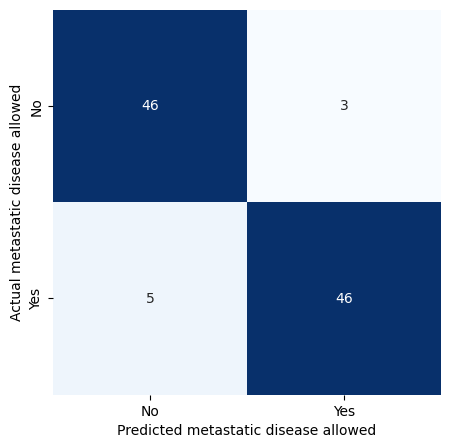

In [15]:
# Create confusion matrix of predicted and actual values for METASTATIC
confusion_matrix = pd.crosstab(
    df_test["METASTATIC"], df_test["METASTATIC_PREDICTED_GPT-4o"]
)

# Plot the confusion matrix
fig = plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted metastatic disease allowed")
plt.ylabel("Actual metastatic disease allowed")
# Remove the colorbar but keep the width of the heatmap
plt.gca().collections[0].colorbar.remove()
plt.xticks([0.5, 1.5], ["No", "Yes"])
plt.yticks([0.5, 1.5], ["No", "Yes"])
plt.show()
fig.savefig(
    "plots/confusion_matrix_metastatic_gpt4o.png", dpi=300, bbox_inches="tight"
)

In [16]:
# Calculate the accuracy of the GPT-4o predictions for METASTATIC
accuracy_metastatic_gpt4o = (
    np.sum(df_test["METASTATIC"] == df_test["METASTATIC_PREDICTED_GPT-4o"])
    / df_test.shape[0]
)

# Estimate the 95% confidence interval for the accuracy
accuracy_metastatic_gpt4o_std = np.sqrt(
    accuracy_metastatic_gpt4o * (1 - accuracy_metastatic_gpt4o) / df_test.shape[0]
)
accuracy_metastatic_gpt4o_CI = 1.96 * accuracy_metastatic_gpt4o_std
print(
    f"Accuracy of GPT-4o predictions for METASTATIC: {accuracy_metastatic_gpt4o:.2f} (95% CI: {accuracy_metastatic_gpt4o - accuracy_metastatic_gpt4o_CI:.2f} - {accuracy_metastatic_gpt4o + accuracy_metastatic_gpt4o_CI:.2f})"
)

# Calculate the precision of the GPT-4o prediction for METASTATIC
precision_metastatic_gpt4o = np.sum(
    (df_test["METASTATIC"] == 1) & (df_test["METASTATIC_PREDICTED_GPT-4o"] == 1)
) / np.sum(df_test["METASTATIC_PREDICTED_GPT-4o"] == 1)

# Estimate the 95 % confidence interval for the precision
precision_metastatic_gpt4o_std = np.sqrt(
    precision_metastatic_gpt4o
    * (1 - precision_metastatic_gpt4o)
    / np.sum(df_test["METASTATIC_PREDICTED_GPT-4o"] == 1)
)
precision_metastatic_gpt4o_CI = 1.96 * precision_metastatic_gpt4o_std
print(
    f"Precision of GPT-4o prediction for METASTATIC: {precision_metastatic_gpt4o:.2f} (95% CI: {precision_metastatic_gpt4o - precision_metastatic_gpt4o_CI:.2f} - {precision_metastatic_gpt4o + precision_metastatic_gpt4o_CI:.2f})"
)

# Calculate the recall of the GPT-4o prediction for METASTATIC
recall_metastatic_gpt4o = np.sum(
    (df_test["METASTATIC"] == 1) & (df_test["METASTATIC_PREDICTED_GPT-4o"] == 1)
) / np.sum(df_test["METASTATIC"] == 1)

# Estimate the 95 % confidence interval for the recall
recall_metastatic_gpt4o_std = np.sqrt(
    recall_metastatic_gpt4o * (1 - recall_metastatic_gpt4o) / np.sum(df_test["METASTATIC"] == 1)
)
recall_metastatic_gpt4o_CI = 1.96 * recall_metastatic_gpt4o_std
print(
    f"Recall of GPT4o prediction for METASTATIC: {recall_metastatic_gpt4o:.2f} (95% CI: {recall_metastatic_gpt4o - recall_metastatic_gpt4o_CI:.2f} - {recall_metastatic_gpt4o + recall_metastatic_gpt4o_CI:.2f})"
)

# Calculate the F1 score of the GPT-4o prediction for METASTATIC
f1_metastatic_gpt4o = (
    2
    * precision_metastatic_gpt4o
    * recall_metastatic_gpt4o
    / (precision_metastatic_gpt4o + recall_metastatic_gpt4o)
)

# Estimate the 95 % confidence interval for the F1 score
f1_metastatic_gpt4o_std = np.sqrt(
    f1_metastatic_gpt4o * (1 - f1_metastatic_gpt4o) / df_test.shape[0]
)
f1_metastatic_gpt4o_CI = 1.96 * f1_metastatic_gpt4o_std
print(
    f"F1 score of GPT-4o prediction for METASTATIC: {f1_metastatic_gpt4o:.2f} (95% CI: {f1_metastatic_gpt4o - f1_metastatic_gpt4o_CI:.2f} - {f1_metastatic_gpt4o + f1_metastatic_gpt4o_CI:.2f})"
)


Accuracy of GPT-4o predictions for METASTATIC: 0.92 (95% CI: 0.87 - 0.97)
Precision of GPT-4o prediction for METASTATIC: 0.94 (95% CI: 0.87 - 1.01)
Recall of GPT4o prediction for METASTATIC: 0.90 (95% CI: 0.82 - 0.98)
F1 score of GPT-4o prediction for METASTATIC: 0.92 (95% CI: 0.87 - 0.97)


In [17]:
# Calculate the accuracy per family of the GPT-4o prediction for METASTATIC
accuracy_metastatic_gpt4o_per_family = df_test.groupby("family").apply(
    lambda x: np.sum(x["METASTATIC"] == x["METASTATIC_PREDICTED_GPT-4o"]) / x.shape[0]
)

# Calculate the precision per family of the GPT-4o prediction for METASTATIC
precision_metastatic_gpt4o_per_family = df_test.groupby("family").apply(
    lambda x: np.sum((x["METASTATIC"] == 1) & (x["METASTATIC_PREDICTED_GPT-4o"] == 1))
    / np.sum(x["METASTATIC_PREDICTED_GPT-4o"] == 1)
)

# Calculate the recall per family of the GPT-4o prediction for METASTATIC
recall_metastatic_gpt4o_per_family = df_test.groupby("family").apply(
    lambda x: np.sum((x["METASTATIC"] == 1) & (x["METASTATIC_PREDICTED_GPT-4o"] == 1))
    / np.sum(x["METASTATIC"] == 1)
)

# Calculate the F1 score per family of the GPT-4o prediction for METASTATIC
f1_metastatic_gpt4o_per_family = (
    2
    * precision_metastatic_gpt4o_per_family
    * recall_metastatic_gpt4o_per_family
    / (precision_metastatic_gpt4o_per_family + recall_metastatic_gpt4o_per_family)
)
# Round the F1 values to two decimal places
f1_metastatic_gpt4o_per_family = f1_metastatic_gpt4o_per_family.round(2)
f1_metastatic_gpt4o_per_family

/var/folders/zl/n32xxxzd1nb405mfhy0jbsdm0000gn/T/ipykernel_72786/922120332.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  accuracy_metastatic_gpt4o_per_family = df_test.groupby("family").apply(
/var/folders/zl/n32xxxzd1nb405mfhy0jbsdm0000gn/T/ipykernel_72786/922120332.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  precision_metastatic_gpt4o_per_family = df_test.groupby("family").apply(
/var/folder

family
All                     0.89
Breast/Gynecological    0.84
Gastrointestinal        1.00
Head & neck             1.00
Lung/Thoracic           1.00
Neuro                    NaN
Skin/Soft tissue        1.00
Urogenital              0.92
dtype: float64

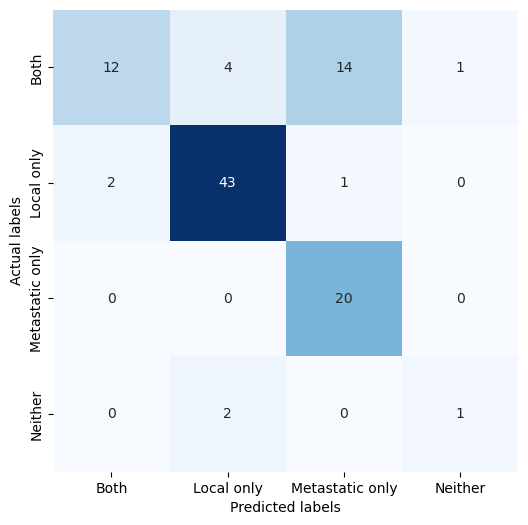

In [18]:
# Create the confusion matrix of predicted and actual values for combined labels
confusion_matrix = pd.crosstab(df_test["ALL_LABELS"], df_test["ALL_LABELS_GPT-4o"])

# Plot the confusion matrix
fig = plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted labels")
plt.ylabel("Actual labels")
plt.xticks([0.5, 1.5, 2.5, 3.5], ["Both", "Local only", "Metastatic only", "Neither"])
plt.yticks([0.5, 1.5, 2.5, 3.5], ["Both", "Local only", "Metastatic only", "Neither"])
# Remove the colorbar but keep the width of the heatmap
plt.gca().collections[0].colorbar.remove()
plt.show()

fig.savefig(
    "plots/confusion_matrix_all_labels_gpt4o.png", dpi=300, bbox_inches="tight"
)

In [21]:
# Calculate the accuracy of the GPT-4o model for all labels
accuracy_combined_gpt4o = (
    np.sum(df_test["ALL_LABELS"] == df_test["ALL_LABELS_GPT-4o"])
    / df_test.shape[0]
)

# Estimate the 95 % confidence interval for the accuracy
accuracy_combined_gpt4o_std = np.sqrt(
    accuracy_combined_gpt4o * (1 - accuracy_combined_gpt4o) / df_test.shape[0]
)
accuracy_combined_gpt4o_CI = 1.96 * accuracy_combined_gpt4o_std
print(
    f"Accuracy of GPT-4o prediction for Both: {accuracy_combined_gpt4o:.2f} (95% CI: {accuracy_combined_gpt4o - accuracy_combined_gpt4o_CI:.2f} - {accuracy_combined_gpt4o + accuracy_combined_gpt4o_CI:.2f})"
)
print("##############################################")

# Calculate the precision of the GPT-4o model for Both
precision_both_gpt4o = np.sum(
    (df_test["ALL_LABELS"] == "Both")
    & (df_test["ALL_LABELS_GPT-4o"] == "Both")
) / np.sum(df_test["ALL_LABELS_GPT-4o"] == "Both")

# Estimate the 95 % confidence interval for the precision
precision_both_gpt4o_std = np.sqrt(
    precision_both_gpt4o
    * (1 - precision_both_gpt4o)
    / np.sum(df_test["ALL_LABELS_GPT-4o"] == "Both")
)
precision_both_gpt4o_CI = 1.96 * precision_both_gpt4o_std
print(
    f"Precision of GPT-4o prediction for Both: {precision_both_gpt4o:.2f} (95% CI: {precision_both_gpt4o - precision_both_gpt4o_CI:.2f} - {precision_both_gpt4o + precision_both_gpt4o_CI:.2f})"
)

# Calculate the recall of the GPT-4o model for Both
recall_both_gpt4o = np.sum(
    (df_test["ALL_LABELS"] == "Both") & (df_test["ALL_LABELS_GPT-4o"] == "Both")
) / np.sum(df_test["ALL_LABELS"] == "Both")

# Estimate the 95 % confidence interval for the recall
recall_both_gpt4o_std = np.sqrt(
    recall_both_gpt4o
    * (1 - recall_both_gpt4o)
    / np.sum(df_test["ALL_LABELS"] == "Both")
)
recall_both_gpt4o_CI = 1.96 * recall_both_gpt4o_std
print(
    f"Recall of GPT-4o prediction for Both: {recall_both_gpt4o:.2f} (95% CI: {recall_both_gpt4o - recall_both_gpt4o_CI:.2f} - {recall_both_gpt4o + recall_both_gpt4o_CI:.2f})"
)

# Calculate the F1 score of the GPT-4o model for Both
f1_both_gpt4o = (
    2
    * precision_both_gpt4o
    * recall_both_gpt4o
    / (precision_both_gpt4o + recall_both_gpt4o)
)

# Estimate the 95 % confidence interval for the F1 score
f1_both_gpt4o_std = np.sqrt(
    f1_both_gpt4o * (1 - f1_both_gpt4o) / df_test.shape[0]
)
f1_both_gpt4o_CI = 1.96 * f1_both_gpt4o_std
print(
    f"F1 score of GPT-4o prediction for Both: {f1_both_gpt4o:.2f} (95% CI: {f1_both_gpt4o - f1_both_gpt4o_CI:.2f} - {f1_both_gpt4o + f1_both_gpt4o_CI:.2f}"
)
print("##############################################")

# Calculate the precision of the GPT-4o model for Local only
precision_local_gpt4o = np.sum(
    (df_test["ALL_LABELS"] == "Local_only")
    & (df_test["ALL_LABELS_GPT-4o"] == "Local_only")
) / np.sum(df_test["ALL_LABELS_GPT-4o"] == "Local_only")


# Estimate the 95 % confidence interval for the precision
precision_local_gpt4o_std = np.sqrt(
    precision_local_gpt4o
    * (1 - precision_local_gpt4o)
    / np.sum(df_test["ALL_LABELS_GPT-4o"] == "Local_only")
)
precision_local_gpt4o_CI = 1.96 * precision_local_gpt4o_std
print(
    f"Precision of GPT-4o prediction for Local only: {precision_local_gpt4o:.2f} (95% CI: {precision_local_gpt4o - precision_local_gpt4o_CI:.2f} - {precision_local_gpt4o + precision_local_gpt4o_CI:.2f})"
)

# Calculate the recall of the GPT-4o model for Local only
recall_local_gpt4o = np.sum(
    (df_test["ALL_LABELS"] == "Local_only")
    & (df_test["ALL_LABELS_GPT-4o"] == "Local_only")
) / np.sum(df_test["ALL_LABELS"] == "Local_only")

# Estimate the 95 % confidence interval for the recall
recall_local_gpt4o_std = np.sqrt(
    recall_local_gpt4o
    * (1 - recall_local_gpt4o)
    / np.sum(df_test["ALL_LABELS"] == "Local_only")
)
recall_local_gpt4o_CI = 1.96 * recall_local_gpt4o_std
print(
    f"Recall of GPT-4o prediction for Local only: {recall_local_gpt4o:.2f} (95% CI: {recall_local_gpt4o - recall_local_gpt4o_CI:.2f} - {recall_local_gpt4o + recall_local_gpt4o_CI:.2f})"
)

# Calculate the F1 score of the GPT-4o model for Local only
f1_local_gpt4o = (
    2
    * precision_local_gpt4o
    * recall_local_gpt4o
    / (precision_local_gpt4o + recall_local_gpt4o)
)

# Estimate the 95 % confidence interval for the F1 score
f1_local_gpt4o_std = np.sqrt(
    f1_local_gpt4o * (1 - f1_local_gpt4o) / df_test.shape[0]
)
f1_local_gpt4o_CI = 1.96 * f1_local_gpt4o_std
print(
    f"F1 score of GPT-4o prediction for Local only: {f1_local_gpt4o:.2f} (95% CI: {f1_local_gpt4o - f1_local_gpt4o_CI:.2f} - {f1_local_gpt4o + f1_local_gpt4o_CI:.2f}"
)
print("##############################################")

# Calculate the precision of the GPT-4o model for Metastatic only
precision_metastatic_gpt4o = np.sum(
    (df_test["ALL_LABELS"] == "Metastatic_only")
    & (df_test["ALL_LABELS_GPT-4o"] == "Metastatic_only")
) / np.sum(df_test["ALL_LABELS_GPT-4o"] == "Metastatic_only")

# Estimate the 95 % confidence interval for the precision
precision_metastatic_gpt4o_std = np.sqrt(
    precision_metastatic_gpt4o
    * (1 - precision_metastatic_gpt4o)
    / np.sum(df_test["ALL_LABELS_GPT-4o"] == "Metastatic_only")
)
precision_metastatic_gpt4o_CI = 1.96 * precision_metastatic_gpt4o_std
print(
    f"Precision of GPT-4o prediction for Metastatic only: {precision_metastatic_gpt4o:.2f} (95% CI: {precision_metastatic_gpt4o - precision_metastatic_gpt4o_CI:.2f} - {precision_metastatic_gpt4o + precision_metastatic_gpt4o_CI:.2f})"
)

# Calculate the recall of the GPT-4o model for Metastatic only
recall_metastatic_gpt4o = np.sum(
    (df_test["ALL_LABELS"] == "Metastatic_only")
    & (df_test["ALL_LABELS_GPT-4o"] == "Metastatic_only")
) / np.sum(df_test["ALL_LABELS"] == "Metastatic_only")

# Estimate the 95 % confidence interval for the recall
recall_metastatic_gpt4o_std = np.sqrt(
    recall_metastatic_gpt4o
    * (1 - recall_metastatic_gpt4o)
    / np.sum(df_test["ALL_LABELS"] == "Metastatic_only")
)
recall_metastatic_gpt4o_CI = 1.96 * recall_metastatic_gpt4o_std
print(
    f"Recall of GPT-4o prediction for Metastatic only: {recall_metastatic_gpt4o:.2f} (95% CI: {recall_metastatic_gpt4o - recall_metastatic_gpt4o_CI:.2f} - {recall_metastatic_gpt4o + recall_metastatic_gpt4o_CI:.2f})"
)

# Calculate the F1 score of the GPT-4o model for Metastatic only
f1_metastatic_gpt4o = (
    2
    * precision_metastatic_gpt4o
    * recall_metastatic_gpt4o
    / (precision_metastatic_gpt4o + recall_metastatic_gpt4o)
)

# Estimate the 95 % confidence interval for the F1 score
f1_metastatic_gpt4o_std = np.sqrt(
    f1_metastatic_gpt4o * (1 - f1_metastatic_gpt4o) / df_test.shape[0]
)
f1_metastatic_gpt4o_CI = 1.96 * f1_metastatic_gpt4o_std
print(
    f"F1 score of GPT-4o prediction for Metastatic only: {f1_metastatic_gpt4o:.2f} (95% CI: {f1_metastatic_gpt4o - f1_metastatic_gpt4o_CI:.2f} - {f1_metastatic_gpt4o + f1_metastatic_gpt4o_CI:.2f})"
)
print("##############################################")

# Calculate the precision of the GPT-4o model for Neither
precision_neither_gpt4o = np.sum(
    (df_test["ALL_LABELS"] == "Neither") & (df_test["ALL_LABELS_GPT-4o"] == "Neither")
) / np.sum(df_test["ALL_LABELS_GPT-4o"] == "Neither")

# Estimate the 95 % confidence interval for the precision
precision_neither_gpt4o_std = np.sqrt(
    precision_neither_gpt4o
    * (1 - precision_neither_gpt4o)
    / np.sum(df_test["ALL_LABELS_GPT-4o"] == "Neither")
)
precision_neither_gpt4o_CI = 1.96 * precision_neither_gpt4o_std
print(
    f"Precision of GPT-4o prediction for Neither: {precision_neither_gpt4o:.2f} (95% CI: {precision_neither_gpt4o - precision_neither_gpt4o_CI:.2f} - {precision_neither_gpt4o + precision_neither_gpt4o_CI:.2f})"
)

# Calculate the recall of the GPT-4o model for Neither
recall_neither_gpt4o = np.sum(
    (df_test["ALL_LABELS"] == "Neither") & (df_test["ALL_LABELS_GPT-4o"] == "Neither")
) / np.sum(df_test["ALL_LABELS"] == "Neither")

# Estimate the 95 % confidence interval for the recall
recall_neither_gpt4o_std = np.sqrt(
    recall_neither_gpt4o
    * (1 - recall_neither_gpt4o)
    / np.sum(df_test["ALL_LABELS"] == "Neither")
)
recall_neither_gpt4o_CI = 1.96 * recall_neither_gpt4o_std

print(
    f"Recall of GPT-4o prediction for Neither: {recall_neither_gpt4o:.2f} (95% CI: {recall_neither_gpt4o - recall_neither_gpt4o_CI:.2f} - {recall_neither_gpt4o + recall_neither_gpt4o_CI:.2f})"
)

# Calculate the F1 score of the GPT-4o model for Neither
f1_neither_gpt4o = (
    2
    * precision_neither_gpt4o
    * recall_neither_gpt4o
    / (precision_neither_gpt4o + recall_neither_gpt4o)
)

# Estimate the 95 % confidence interval for the F1 score
f1_neither_gpt4o_std = np.sqrt(
    f1_neither_gpt4o * (1 - f1_neither_gpt4o) / df_test.shape[0]
)
f1_neither_gpt4o_CI = 1.96 * f1_neither_gpt4o_std
print(
    f"F1 score of GPT-4o prediction for Neither: {f1_neither_gpt4o:.2f} (95% CI: {f1_neither_gpt4o - f1_neither_gpt4o_CI:.2f} - {f1_neither_gpt4o + f1_neither_gpt4o_CI:.2f})"
)

Accuracy of GPT-4o prediction for Both: 0.76 (95% CI: 0.68 - 0.84)
##############################################
Precision of GPT-4o prediction for Both: 0.86 (95% CI: 0.67 - 1.04)
Recall of GPT-4o prediction for Both: 0.39 (95% CI: 0.22 - 0.56)
F1 score of GPT-4o prediction for Both: 0.53 (95% CI: 0.44 - 0.63
##############################################
Precision of GPT-4o prediction for Local only: 0.88 (95% CI: 0.79 - 0.97)
Recall of GPT-4o prediction for Local only: 0.93 (95% CI: 0.86 - 1.01)
F1 score of GPT-4o prediction for Local only: 0.91 (95% CI: 0.85 - 0.96
##############################################
Precision of GPT-4o prediction for Metastatic only: 0.57 (95% CI: 0.41 - 0.74)
Recall of GPT-4o prediction for Metastatic only: 1.00 (95% CI: 1.00 - 1.00)
F1 score of GPT-4o prediction for Metastatic only: 0.73 (95% CI: 0.64 - 0.81)
##############################################
Precision of GPT-4o prediction for Neither: 0.50 (95% CI: -0.19 - 1.19)
Recall of GPT-4o predict